# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Reading in data
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# Checking head of data
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


I need to resample the taxi order data by the hour. First, I will make sure that the data is in order and clean.

In [4]:
# Making sure that the index is in the correct chronological order
taxi.index.is_monotonic

True

In [5]:
# Checking info
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Looks like there's no missing data.

In [6]:
# Checking for duplicates
taxi.index.duplicated().sum()

0

In [7]:
# Resampling data by one hour
taxi = taxi.resample('1H').sum()

The data seems to be clean and I've resampled it by one hour. Now it's ready for analysis.

## Analysis

Before training my models I will make a few plots and try to understand the data.

In [8]:
# Decomposing taxi data
taxi_decomposed = seasonal_decompose(taxi)

In [9]:
# Adding a rolling mean feature
taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(15).mean()

In [10]:
# Adding a rolling standard deviation feature
taxi['rolling_std'] = taxi['num_orders'].shift().rolling(15).std()

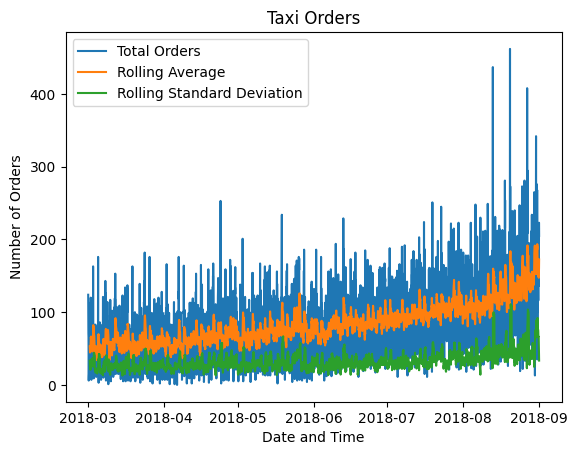

In [11]:
# Plotting the full DataFrame
plt.plot(taxi)
plt.title('Taxi Orders')
plt.legend(['Total Orders', 'Rolling Average', 'Rolling Standard Deviation'])
plt.xlabel('Date and Time')
plt.ylabel('Number of Orders')
plt.show()

Looks like the number of orders increases over time with some pretty significant spikes. 

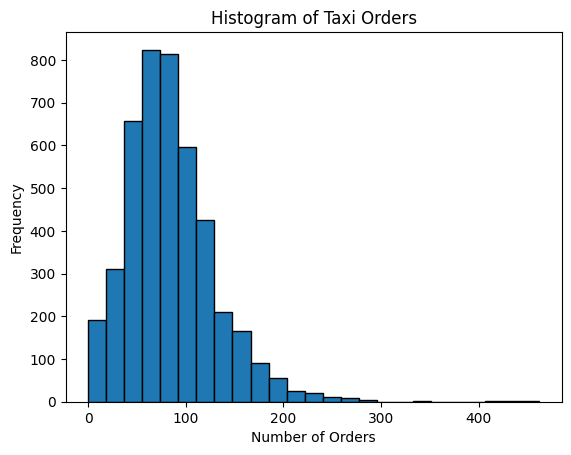

In [12]:
# Plotting a histogram of orders
plt.hist(taxi['num_orders'], bins=25, edgecolor='black')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.title('Histogram of Taxi Orders')
plt.show()

Seems like the distribution peaks between around 60-100 orders per hour with most hours having less than about 150 orders. We can also see the outliers identified in the previous plot.

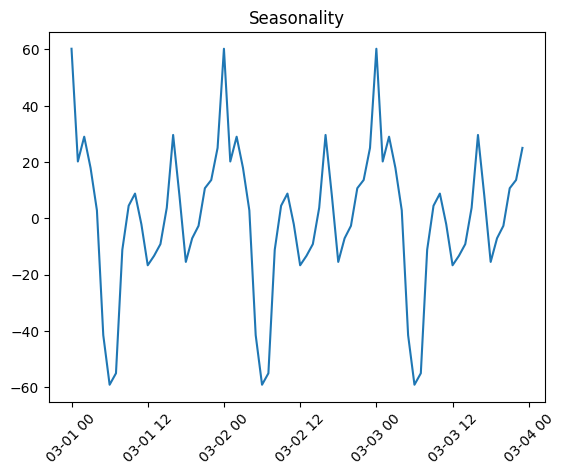

In [13]:
# Plotting seasonality
plt.plot(taxi_decomposed.seasonal['2018-03':'2018-03-03'])
plt.xticks(rotation=45)
plt.title('Seasonality')
plt.show()

Seems like there is a daily pattern in the data.

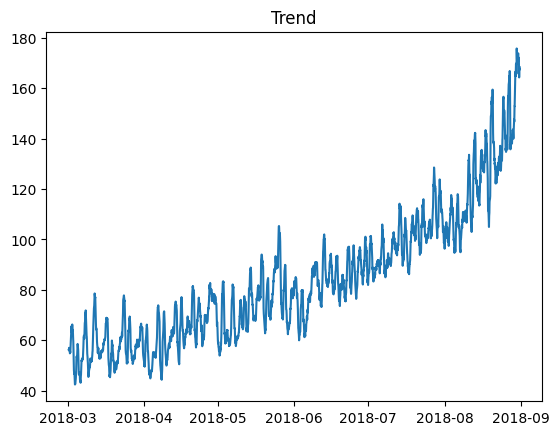

In [14]:
# Plotting trend
plt.plot(taxi_decomposed.trend)
plt.title('Trend')
plt.show()

There is a noticeable trend upwards in the data that can be identified by the increasing mean in the plot of full dataset.

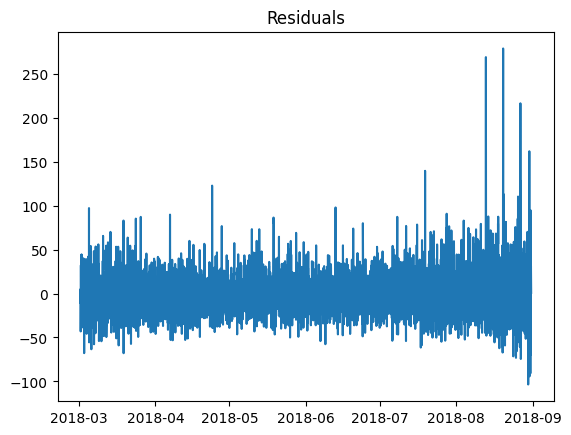

In [15]:
# Plotting Residuals
plt.plot(taxi_decomposed.resid)
plt.title('Residuals')
plt.show()

There's also a lot of variability in the data from one hour to the next.

## Training

I'm  going to train a Linear Regression, Random Forest Regressor and a Decision Tree Regressor to predict the number of orders in the next hour. I will evaluate the results using RMSE (Root Mean Squared Error). I will use cross validation for each model.

In [16]:
# Defining a function to add useful features to the dataset
def make_features(data, max_lag):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [17]:
# Adding features to the dataset
make_features(taxi, 6)

In [18]:
# Checking the head with new features
taxi.head(16)

,num_orders,rolling_mean,rolling_std,year,month,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,2018,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,2018,3,1,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2018,3,1,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,2018,3,1,4,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,NaN,NaN,2018,3,1,5,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,NaN,NaN,2018,3,1,6,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 07:00:00,15,NaN,NaN,2018,3,1,7,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 08:00:00,34,NaN,NaN,2018,3,1,8,15.0,12.0,6.0,43.0,66.0,71.0


In [19]:
# Dropping null data
taxi = taxi.dropna()

In [20]:
# Splitting data
features = taxi.drop('num_orders', axis=1)
target = taxi['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [21]:
# Checking shape of the training and test sets
print('features_train shape', features_train.shape)
print('features_test shape', features_test.shape)
print('target_train shape', target_train.shape)
print('target_test shape', target_test.shape)

features_train shape (3960, 12)
features_test shape (441, 12)
target_train shape (3960,)
target_test shape (441,)


In [22]:
# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

In [23]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [24]:
# Define the model
lr_model = LinearRegression()

# Perform cross-validation with RMSE
lr_scores = cross_val_score(lr_model, features_train, target_train , cv=tscv, scoring=rmse_scorer)

# Print the RMSE scores
print("RMSE scores for each fold:", lr_scores)
print("Mean RMSE:", lr_scores.mean())
print("Standard Deviation of RMSE:", lr_scores.std())

RMSE scores for each fold: [26.95245769 29.01330381 30.33036278 31.86544066 39.50670021]
Mean RMSE: 31.53365302986644
Standard Deviation of RMSE: 4.300394927040993


In [25]:
# Saving empty variables
best_est = 0
best_rf_scores = []
best_rf_mean_rmse = float('inf')
best_rf_std_rmse = 0

# for loop finding choosing the best number of estimators
for n in range(1, 26):
    # Define the model
    rf_model = RandomForestRegressor(n_estimators=n, random_state=42)
    
    # Perform cross-validation with RMSE
    rf_scores = cross_val_score(rf_model, features_train, target_train, cv=tscv, scoring=rmse_scorer)
    
    # Average rmse
    rf_mean_rmse = rf_scores.mean()
    
    # Saving scores for the best depth
    if rf_mean_rmse < best_rf_mean_rmse and rf_mean_rmse > 0:
        best_est = n
        best_rf_scores = rf_scores
        best_rf_mean_rmse = rf_mean_rmse
        best_rf_std_rmse = rf_scores.std()

# Printing results
print('Best est:', best_est)
print('Best RMSE scores for each fold:', best_rf_scores)
print('Best Mean RMSE:', best_rf_mean_rmse)
print('Best Standard Deviation of RMSE:', best_rf_std_rmse)

Best est: 20
Best RMSE scores for each fold: [24.17020353 24.71675208 23.94644878 25.38605282 31.48629789]
Best Mean RMSE: 25.941151019385142
Best Standard Deviation of RMSE: 2.8167723579880812


In [26]:
# Saving empty variables
best_depth = 0
best_dt_scores = []
best_dt_mean_rmse = float('inf')
best_dt_std_rmse = 0

# for loop finding choosing the best depth
for n in range(1, 26):
    # Define the model
    dt_model = DecisionTreeRegressor(max_depth=n, random_state=42)
    
    # Perform cross-validation with RMSE
    dt_scores = cross_val_score(dt_model, features_train, target_train, cv=tscv, scoring=rmse_scorer)
    
    # Average rmse
    dt_mean_rmse = dt_scores.mean()
    
    # Saving scores for the best depth
    if dt_mean_rmse < best_dt_mean_rmse and dt_mean_rmse > 0:
        best_depth = n
        best_dt_scores = dt_scores
        best_dt_mean_rmse = dt_mean_rmse
        best_dt_std_rmse = dt_scores.std()

# Printing results
print('Best depth:', best_depth)
print('Best RMSE scores for each fold:', best_dt_scores)
print('Best Mean RMSE:', best_dt_mean_rmse)
print('Best Standard Deviation of RMSE:', best_dt_std_rmse)

Best depth: 6
Best RMSE scores for each fold: [27.62684216 29.58024323 29.64038602 29.08672773 37.3354617 ]
Best Mean RMSE: 30.653932168714295
Best Standard Deviation of RMSE: 3.4188396958333245


Looks like the Random Forest Regressor has the best average RMSE with 25 estimators. It's also interesting to note that the RMSE scores increase on each fold of cross validation. This must be due to the increasing trend in the data.

## Testing

Now, using the hyperparameters selected from the last step I will test the models.

In [27]:
lr_model.fit(features_train, target_train)
final_lr_pred = lr_model.predict(features_test)
final_lr_rmse = mean_squared_error(target_test, final_lr_pred, squared=False)

print('Linear Regression Final RMSE:', final_lr_rmse)

Linear Regression Final RMSE: 53.92546570477185


In [28]:
final_rf_model = RandomForestRegressor(n_estimators=best_est, random_state=42)
final_rf_model.fit(features_train, target_train)
final_rf_pred = final_rf_model.predict(features_test)
final_rf_rmse = mean_squared_error(target_test, final_rf_pred, squared=False)

print('Random Forest Final RMSE:', final_rf_rmse)

Random Forest Final RMSE: 44.3178405618267


In [29]:
final_dt_model = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
final_dt_model.fit(features_train, target_train)
final_dt_pred = final_dt_model.predict(features_test)
final_dt_rmse = mean_squared_error(target_test, final_dt_pred, squared=False)

print('Decision Tree Final RMSE:', final_dt_rmse)

Decision Tree Final RMSE: 55.88118924964261


Here we can see increased RMSE scores for each model but that makes sense considering that this is the end of the time series where the data trend is peaking compared to the training set. The Random Forest Regressor had the best RMSE score again. It's RMSE score was 44.32 which is under the benchmark of 48.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48